In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt;
from DataSet import *
import os

import sys
sys.path.append("..")
import TargetApplicationScope

%matplotlib notebook

# Compiling/Sampling of Data 

### Random Generation
Coordinates: are randomly generated 
Datetime: points are randomly generated between a range in the past 
Speed: 

### Multivariate 
Elevation 
Temperature 
RainSensor 

### GTSBD:
SignType: labelled from the dataset


In [17]:
## if not generated!

data_file_path = "data/generated_data.csv"
exists = os.path.isfile(data_file_path)
if exists:
    # Store configuration file values
    print("File exists")
    data_set = pd.read_csv(data_file_path)
else:
    print("File does not exist")
    data_set = generate_dataset(data_file_path)
    data_set.to_csv("data/generated_data.csv")

File exists


In [18]:
t = TargetApplicationScope.TargetApplicationScope()
lookup_table = t.__dict__
appropriate_test_cases = 5

In [19]:
selected_sample = 2000
chosen_idx = np.random.choice(selected_sample, replace=False, size=selected_sample)
df_trimmed = data_set.iloc[chosen_idx]
print(df_trimmed.describe())


        Unnamed: 0       Width       Height       Roi.X1       Roi.Y1  \
count  2000.000000  2000.00000  2000.000000  2000.000000  2000.000000   
mean    999.500000    47.22250    47.860000     5.815500     5.839000   
std     577.494589    20.09308    20.268147     1.139346     1.160928   
min       0.000000    25.00000    26.000000     5.000000     5.000000   
25%     499.750000    34.00000    34.000000     5.000000     5.000000   
50%     999.500000    41.50000    42.000000     6.000000     6.000000   
75%    1499.250000    53.00000    54.000000     6.000000     6.000000   
max    1999.000000   182.00000   180.000000    16.000000    16.000000   

            Roi.X2      Roi.Y2      ClassId     Latitude    Longitude  \
count  2000.000000  2000.00000  2000.000000  2000.000000  2000.000000   
mean     41.774000    42.39100     1.825000    50.478364    10.012169   
std      19.215164    19.37738     0.845418     2.653649     2.317250   
min      20.000000    20.00000     0.000000    46.

# Coverage/Sufficiency aspects

### Range-based Parameters
Verifies parameters fit between the TAS application_scope {min/max_values}



In [20]:
## Range related parameters: just checking min & max
def return_min_max(column):
    """ returns the max & min on column [min, max]"""
    return [min(column), max(column)]


def check_range(tas_parms, column, sufficency = 0 ):
    min_max = return_min_max(column)
    for key in tas_parms:
        if "min" in key:
            if tas_parms[key] <= min_max[0]:
                sufficency = sufficency + 0.5
        if "max" in key:
            if tas_parms[key] >= min_max[1]:
                sufficency = sufficency + 0.5
    return sufficency

In [21]:
def validate_range_based_params(data, test_cases):
    """
     Range-based:
    + temperatureRange(temperature, min_temp, max_temp):
    + velocityRange(min_velocity, max_velocity)
    + rainSensorRange(min_rain, max_rain): TODO:
    + elevationSensorRange(min_elevation, max_elevation)
    + yearRange(year, timestamp)
    """
    #  + velocityRange(min_velocity, max_velocity)
    validation = check_range(lookup_table['temperature'], data['Temperature']) + \
                 check_range(lookup_table['velocity'], data['Speed'] ) +\
                 check_range(lookup_table['elevation'], data['Elevation']) 
            
    return validation/test_cases

validate_range_based_params(df_trimmed, 3)

0.8333333333333334

## Density-Based Parameters 

### Coordinates
-- plots Density Based Coordinates
-- verifies there are neighbors within 4km squared {how many neighbors?}
@todo: need to add that they are along the border of Germany


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


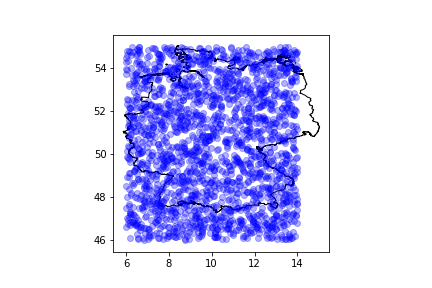

In [23]:
import geopandas as gpd
import shapely
import pandas as pd
import geopandas
from shapely.geometry import Point
from geopy import distance


def plot_coordinates():
    df_trimmed['Coordinates_Joined'] = list(zip(df_trimmed.Longitude, df_trimmed.Latitude))
    gdf = geopandas.GeoDataFrame(df_trimmed, geometry=df_trimmed['Coordinates_Joined'].apply(Point))
    germany_plot = gpd.read_file("shp/Germanyboundary87.shp")
    ax = germany_plot.plot(
        color='white', edgecolor='black')
    gdf.plot(ax=ax, color='blue',alpha=0.3)


    
plot_coordinates()
   

In [29]:
## HAVERSINE & KD TREE
# @todo: fix strategy
import numpy as np
from scipy.spatial import cKDTree

tree = cKDTree(list(df_trimmed['Coordinates_Joined']))
dist = 4
for x in df_trimmed['Coordinates_Joined']:
    ix = tree.query_ball_point(x, dist)
    if len(ix) < 1:
        print("No points")
    else: 
        print(str(x)+ "Has" + str(len(ix)) + "Neighbors")


def find_neighbours_within_radius(xy, radius):
    tree = cKDTree(xy)
    within_radius = tree.query_ball_tree(tree, r=radius)
    return within_radius

def flatten_nested_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

def total_neighbours_within_radius(xy, radius):
    neighbours = find_neighbours_within_radius(xy, radius)
    return len(flatten_nested_list(neighbours))


493                  (10.16033044, 51.02439369)
811            (9.207065047999999, 47.36178757)
1209                 (10.85552822, 53.57790722)
1928                 (10.97590255, 52.96554889)
28                   (11.85197345, 49.74979963)
1245                 (12.53966076, 54.69616946)
1804                 (6.180274879, 51.72070562)
1520                 (8.705449556, 47.51221606)
1572                   (12.75148118, 50.705039)
1266                  (7.32383956, 54.20441871)
840           (10.63477008, 50.572416499999996)
55                    (6.578023175, 46.0325674)
1292                 (12.90312219, 53.57313918)
1638                   (11.254139, 48.71733642)
36                   (12.99791856, 46.48550519)
580                  (12.70584931, 53.18492023)
1611                 (11.73219469, 54.63898984)
885                    (12.1973383, 48.0919185)
389                  (9.555595501, 51.79239582)
636                  (7.547955385, 53.01266151)
1225                 (11.38246721, 54.02

(10.20623027, 47.61248631)Has1037Neighbors
(6.869120167999999, 51.19664558)Has869Neighbors
(10.56666315, 47.28648399)Has963Neighbors
(10.15037315, 46.11646123)Has733Neighbors
(8.778045401, 49.10721302)Has1158Neighbors
(12.62459356, 51.16042024)Has964Neighbors
(7.191253991, 53.07675322)Has738Neighbors
(8.645603925, 48.6894188)Has1087Neighbors
(8.78982055, 46.32694657)Has705Neighbors
(13.00450049, 48.78809372)Has801Neighbors
(8.084003862000001, 51.65789626)Has1069Neighbors
(13.49881213, 53.81336238)Has545Neighbors
(13.48285793, 53.81315701)Has547Neighbors
(8.580407426, 54.98794867)Has609Neighbors
(13.98773066, 47.63975177)Has514Neighbors
(9.574188714, 49.69557485)Has1333Neighbors
(13.59090811, 47.82162198)Has600Neighbors
(13.30458795, 48.91053961)Has750Neighbors
(7.450820142, 47.01458215)Has660Neighbors
(9.504210829, 51.56384466)Has1284Neighbors
(13.8903892, 50.94785979)Has697Neighbors
(11.10118735, 54.42740109)Has758Neighbors
(8.091286792, 54.97797316)Has582Neighbors
(12.76515021, 47.46

(8.098336864, 47.40162949)Has802Neighbors
(8.558548661, 49.66837066)Has1186Neighbors
(9.733804702999999, 50.54104818)Has1360Neighbors
(10.99427726, 53.43269472)Has935Neighbors
(12.25901947, 49.09789094)Has988Neighbors
(10.42605273, 54.92021161)Has707Neighbors
(6.839192886, 46.00127407)Has455Neighbors
(10.34629433, 46.79947316)Has885Neighbors
(12.3186739, 50.7441991)Has1032Neighbors
(9.685222493, 47.45068951)Has992Neighbors
(8.964530202, 48.50102718)Has1092Neighbors
(8.101361552, 53.74383643)Has777Neighbors
(11.88250107, 54.33947359)Has690Neighbors
(6.549610786000001, 50.03710437)Has808Neighbors
(7.37060485, 50.79955344)Has968Neighbors
(13.46440655, 47.13076804)Has535Neighbors
(13.96532263, 54.78284212)Has389Neighbors
(13.22460497, 49.47491919)Has821Neighbors
(6.508878469, 51.44965464)Has786Neighbors
(13.23849323, 49.27477983)Has798Neighbors
(7.7875824510000005, 51.22277229)Has1063Neighbors
(6.888238477000001, 53.54448725)Has631Neighbors
(10.05465609, 53.05418016)Has1097Neighbors
(11.99

(13.05377748, 46.91490279)Has571Neighbors
(12.36371215, 47.46207384)Has731Neighbors
(13.5189016, 52.0911362)Has711Neighbors
(10.25358024, 46.47430635)Has813Neighbors
(7.948959392999999, 49.72736563)Has1082Neighbors
(10.41901923, 47.04057366)Has925Neighbors
(13.35291029, 50.76756276)Has824Neighbors
(11.85812747, 46.32340724)Has641Neighbors
(8.01629936, 47.43417896)Has802Neighbors
(12.40561676, 53.44474361)Has748Neighbors
(7.340920755, 47.3436407)Has690Neighbors
(7.98091836, 52.3175454)Has967Neighbors
(7.726972441, 48.62958829)Has924Neighbors
(8.329717687999999, 51.03817216)Has1157Neighbors
(13.63060823, 54.14172972)Has490Neighbors
(13.53682428, 52.54587236)Has667Neighbors
(11.07927928, 53.21165219)Has975Neighbors
(13.66964958, 48.44487987)Has636Neighbors
(8.759171291, 53.53464612)Has901Neighbors
(11.33499318, 46.94250292)Has805Neighbors
(8.615443012, 48.74208939)Has1085Neighbors
(6.077408136, 50.882730200000005)Has719Neighbors
(12.53095434, 46.20836134)Has554Neighbors
(7.795702856, 47.0

# Density-Based Parameters 

### Datetime


@todo: need to add that they are along the border of Germany

In [34]:
from datetime import datetime

## maybe this should use the actaul data_set {not a sample of it} -> Insufficent data points 

data_set['Timestamp'] =  pd.to_datetime(data_set['Datetime'], unit='s')
data_set.index = data_set['Timestamp']
# test case should be 4
data_set.resample('60T').count()
resample = data_set.resample('60T').count()
print(resample[resample['Filename'] <= 1] )

                     Unnamed: 0  Filename  Width  Height  Roi.X1  Roi.Y1  \
Timestamp                                                                  
2018-04-02 13:00:00           1         1      1       1       1       1   
2018-04-02 15:00:00           0         0      0       0       0       0   
2018-04-02 16:00:00           1         1      1       1       1       1   
2018-04-02 19:00:00           1         1      1       1       1       1   
2018-04-02 20:00:00           1         1      1       1       1       1   
2018-04-02 22:00:00           1         1      1       1       1       1   
2018-04-03 02:00:00           0         0      0       0       0       0   
2018-04-03 03:00:00           1         1      1       1       1       1   
2018-04-03 05:00:00           1         1      1       1       1       1   
2018-04-03 07:00:00           1         1      1       1       1       1   
2018-04-03 10:00:00           0         0      0       0       0       0   
2018-04-03 1

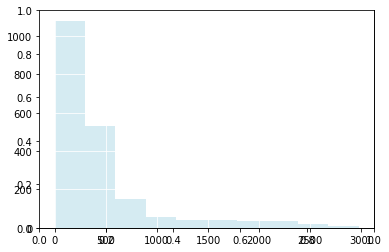

In [30]:
## Distribution -> https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
## Elevation of Germany 

fig, ax = plt.subplots()

ax = fig.add_subplot(111)
ax.grid(color='white', linestyle='solid')

x = np.random.normal(size=1000)
ax.hist(df_trimmed['Elevation'], histtype='stepfilled', fc='lightblue', alpha=0.5);


# Representativeness aspects

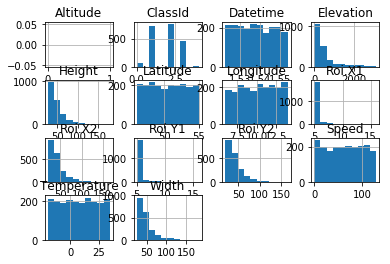

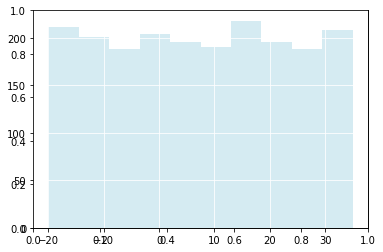

In [10]:
## can use some of the Weather sampling code
df_trimmed.hist()


fig, ax = plt.subplots()

ax = fig.add_subplot(111)
ax.grid(color='white', linestyle='solid')

x = np.random.normal(size=1000)
ax.hist(df_trimmed['Temperature'], histtype='stepfilled', fc='lightblue', alpha=0.5);

